In [20]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import statsmodels.formula.api as ols

In [21]:
# Configuration
FILE_PATH = 'Region_US48.xlsx'
START_DATE = '2019-01-01'
END_DATE = '2025-12-31'

# ==========================================
# 2. LOAD & PREP DATA
# ==========================================
print(" Loading data...")
df = pd.read_excel(FILE_PATH)
df.columns = df.columns.str.strip()

# Parse Dates
df['date_hour'] = pd.to_datetime(df['UTC time'])
df['date'] = df['date_hour'].dt.date
df['year'] = df['date_hour'].dt.year
df['month'] = df['date_hour'].dt.month
df['hour'] = df['date_hour'].dt.hour

# Filter Date Range
df = df[
    (df['date'] >= pd.to_datetime(START_DATE).date()) & 
    (df['date'] <= pd.to_datetime(END_DATE).date())
].copy()

# Create Time Trend (t=0, 1, 2...) for the interaction term
min_year = df['year'].min()
df['time_trend'] = df['year'] - min_year

# Rename Columns for easier formulas
rename_map = {
    'Demand': 'Load',
    'NG: COL': 'Gen_Coal',
    'NG: NG': 'Gen_Gas',
}
df = df.rename(columns=rename_map)
# Convert units
df['Gen_Coal_mkwh'] = df['Gen_Coal'] 
df['Gen_Gas_mkwh'] = df['Gen_Gas'] 
 
# --- Select final columns  ---
keep_cols = [
     'date', 'year', 'month', 'hour', 
     'Load', 'Gen_Coal_mkwh', 'Gen_Gas_mkwh'
]
# Clean data (remove rows where Gen_Coal or Gen_Gas is NaN)
df = df.dropna(subset=['Load', 'Gen_Coal_mkwh', 'Gen_Gas_mkwh'])
final_df = df[[col for col in keep_cols if col in df.columns]].copy()

 Loading data...


In [22]:
final_df

,date,year,month,hour,Load,Gen_Coal_mkwh,Gen_Gas_mkwh
30715,2019-01-01,2019,1,0,461392.0,109616.0,130005.0
30716,2019-01-01,2019,1,1,459577.0,108132.0,130123.0
30717,2019-01-01,2019,1,2,451601.0,103544.0,124526.0
30718,2019-01-01,2019,1,3,437803.0,98623.0,115430.0
30719,2019-01-01,2019,1,4,422742.0,95047.0,106956.0
...,...,...,...,...,...,...,...
92078,2025-12-31,2025,12,19,507946.0,97585.0,166513.0
92079,2025-12-31,2025,12,20,502367.0,92832.0,164730.0
92080,2025-12-31,2025,12,21,498110.0,89705.0,166528.0
92081,2025-12-31,2025,12,22,503223.0,90575.0,175617.0


In [23]:
# ==========================================
# 2. CALCULATE VECTORS (Holland Methodology)
# ==========================================
from statsmodels.regression.linear_model import OLS
from patsy import dmatrices
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = []

for yr in final_df['year'].unique():
    sub = final_df[final_df['year'] == yr].copy()
    
    # --- A. Average Vector (Volume Share) ---
    total_fossil = sub['Gen_Coal_mkwh'].sum() + sub['Gen_Gas_mkwh'].sum()
    avg_vec = [
        sub['Gen_Coal_mkwh'].sum() / total_fossil,  # Coal Share
        sub['Gen_Gas_mkwh'].sum() / total_fossil,   # Gas Share
    ]
    
    # --- B. Marginal Vector (Regression Slopes with Controls) ---
    beta_values = {'beta_coal': 0, 'beta_gas': 0}
    se_values = {'se_coal': 0, 'se_gas': 0}
    
    for gen in ['Gen_Coal_mkwh', 'Gen_Gas_mkwh']:
        # Define formula with control variables
        formula = f'{gen} ~ Load + C(hour) * C(month)'
        
        # Create design matrices using patsy
        y, X = dmatrices(formula, data=sub, return_type='dataframe')
        
        # Fit regression model
        model = OLS(y, X).fit()
        # Extract coefficient and standard error for the generation variable
        beta = model.params['Load']
        se = model.bse['Load']
        
        fuel_type = gen.split('_')[1].lower()
        beta_values[f'beta_{fuel_type}'] = beta
        se_values[f'se_{fuel_type}'] = se
    

    marg_vec = [beta_values['beta_coal'], beta_values['beta_gas']]
    marg_se = [se_values['se_coal'], se_values['se_gas']]
    
    results.append({
        'year': yr,
        'avg_coal': avg_vec[0],
        'avg_gas': avg_vec[1],
        'marg_coal': marg_vec[0],
        'marg_gas': marg_vec[1],
        'se_coal': marg_se[0],
        'se_gas': marg_se[1]
    })

results_df = pd.DataFrame(results)
print(results_df)


   year  avg_coal   avg_gas  marg_coal  marg_gas   se_coal    se_gas
0  2019  0.393153  0.606847   0.394415  0.519480  0.002414  0.003047
1  2020  0.339919  0.660081   0.342005  0.576413  0.002771  0.004086
2  2021  0.384659  0.615341   0.325736  0.604961  0.002654  0.003823
3  2022  0.354802  0.645198   0.298262  0.578082  0.002397  0.004043
4  2023  0.293488  0.706512   0.271294  0.540368  0.002172  0.004000
5  2024  0.279296  0.720704   0.305461  0.530113  0.002170  0.004225
6  2025  0.308637  0.691363   0.292281  0.584980  0.002152  0.003884


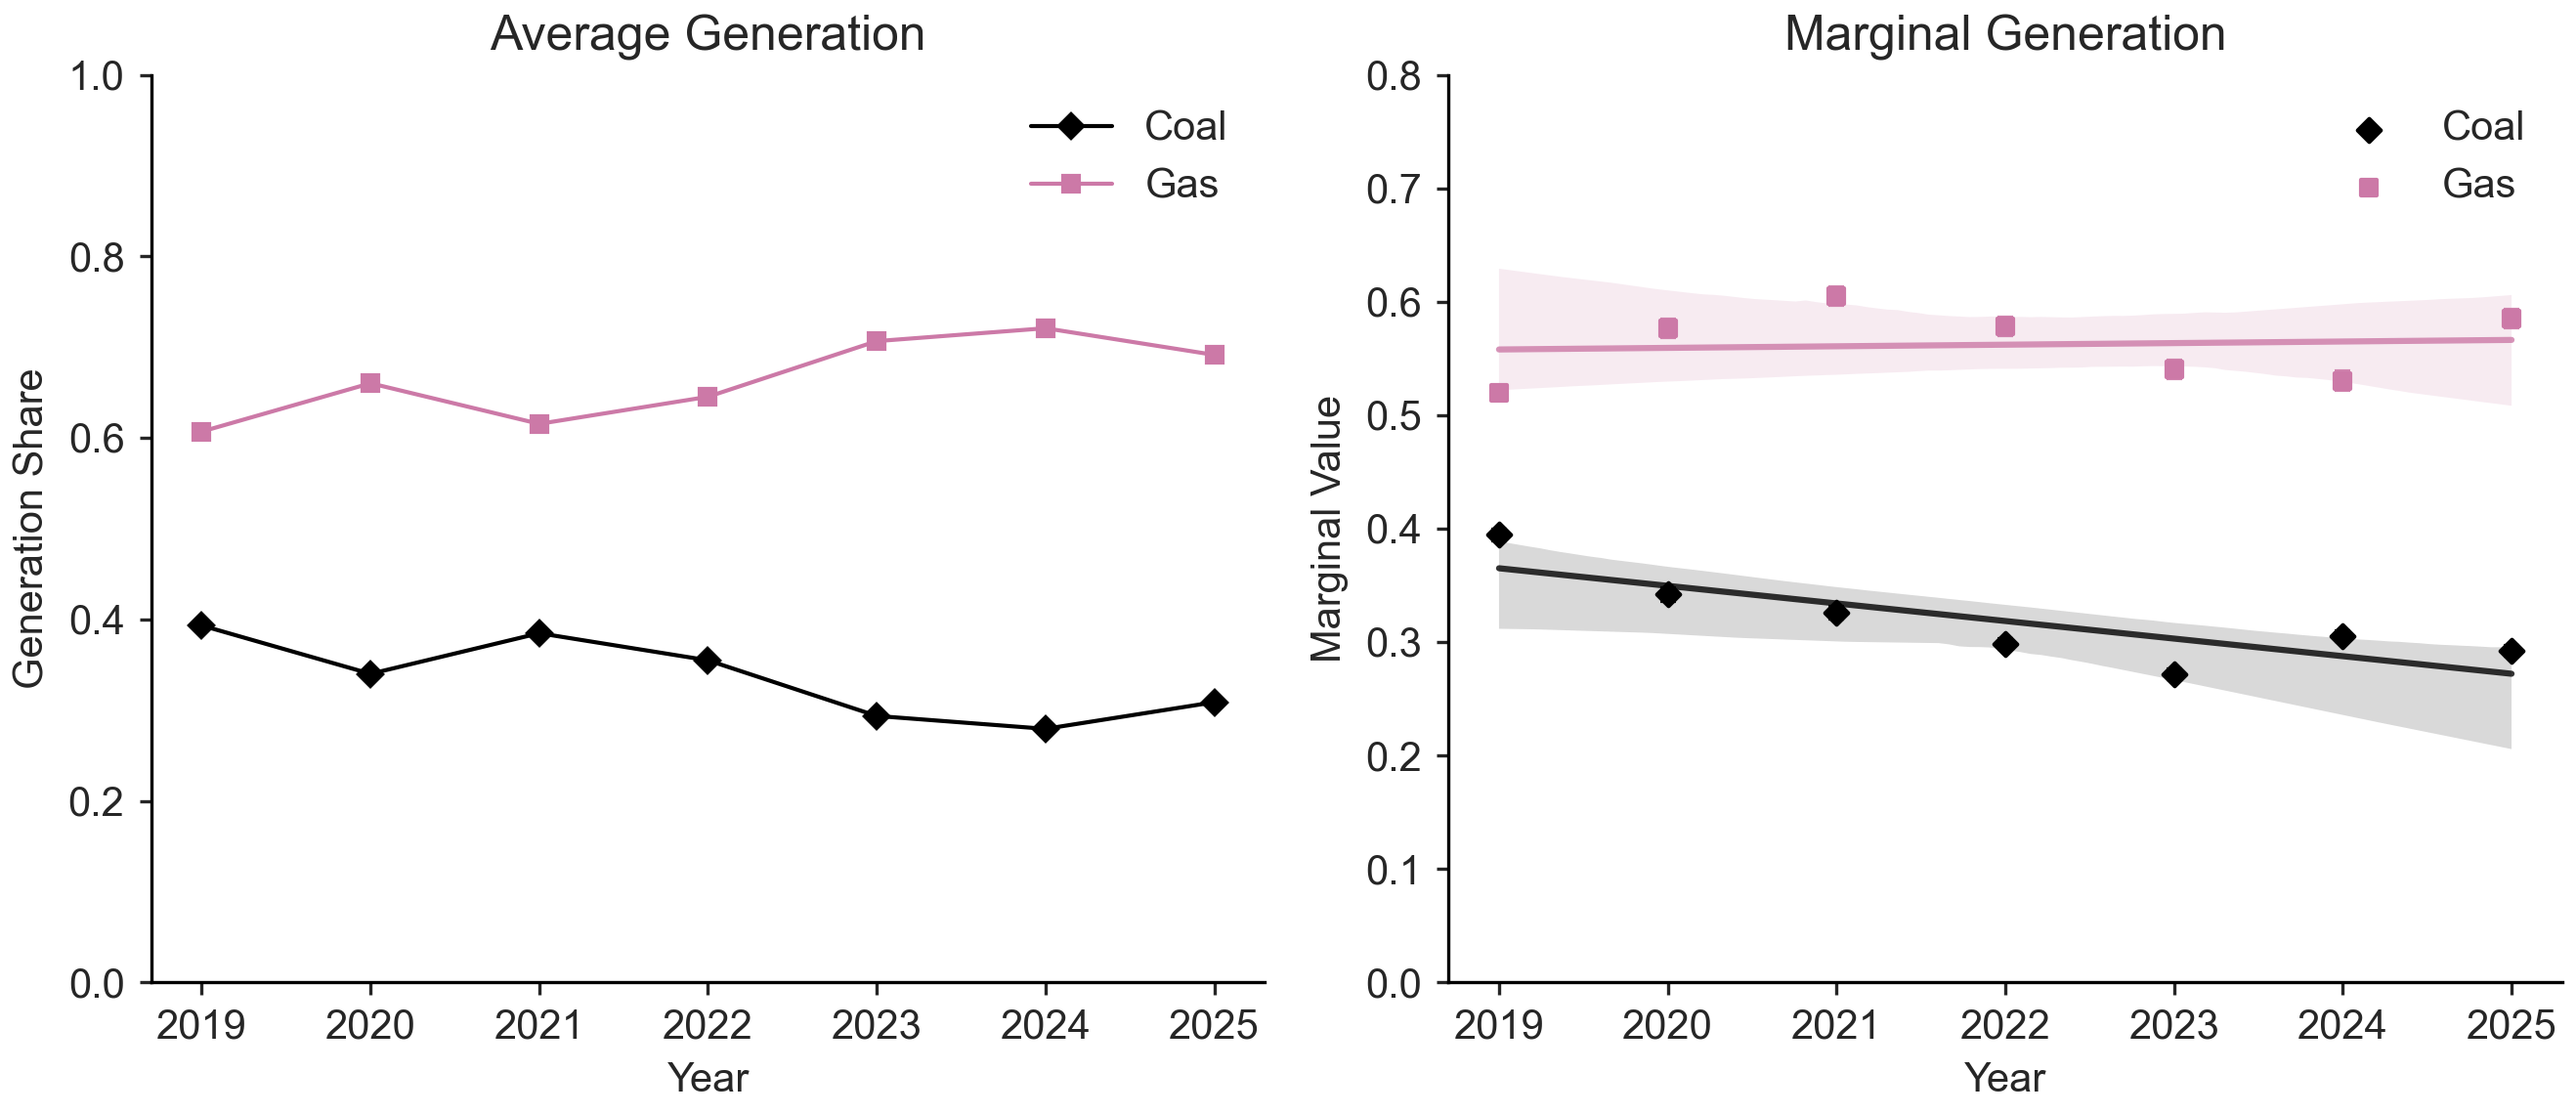

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 1. Define the Publication Style Function
def set_publication_style(use_latex=False):
    """
    Apply a publication-quality Matplotlib style.
    Optimized for figures intended for journals (Nature, Science, PNAS, etc.).
    """
    # 1️⃣ BASE STYLE
    plt.style.use('seaborn-v0_8-white')

    # 2️⃣ FONT SETTINGS
    font_params = {
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'mathtext.fontset': 'stixsans',
    }

    # 3️⃣ LATEX RENDERING
    if use_latex:
        font_params.update({
            'text.usetex': True,
            'font.family': 'serif',
            'text.latex.preamble': r'\usepackage{amsmath} \usepackage{helvet} \usepackage{sansmath} \sansmath'
        })

    # 4️⃣ AXES & GRID STYLE
    axes_params = {
        'axes.edgecolor': 'black',
        'axes.linewidth': 0.8,
        'axes.grid': False,
        'grid.alpha': 0.3,
        'axes.axisbelow': True,
        'axes.spines.top': False,
        'axes.spines.right': False,
    }

    # 5️⃣ TICKS
    tick_params = {
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.visible': True,
        'ytick.minor.visible': True,
    }

    # 6️⃣ COLORBLIND-FRIENDLY PALETTE (Okabe–Ito)
    cb_palette = [
        '#E69F00', '#56B4E9', '#009E73', '#F0E442',
        '#0072B2', '#D55E00', '#CC79A7', '#000000'
    ]

    # 7️⃣ APPLY SETTINGS
    mpl.rcParams.update(font_params)
    mpl.rcParams.update(axes_params)
    mpl.rcParams.update(tick_params)
    mpl.rcParams.update({
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        'axes.prop_cycle': plt.cycler('color', cb_palette),
    })

# 2. Apply Style
set_publication_style()


# Using specific colors from the style's palette:
# #000000 (Black) for Coal
# #CC79A7 (Reddish Purple) for Gas
color_coal = '#000000'
color_gas = '#CC79A7'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# --- Left Plot: Average ---
ax1.plot(results_df['year'], results_df['avg_coal'], label='Coal', 
         color=color_coal, marker='D')
ax1.plot(results_df['year'], results_df['avg_gas'], label='Gas', 
         color=color_gas, marker='s')

ax1.set_title('Average Generation')
ax1.set_ylabel('Generation Share')
ax1.set_ylim(0, 1.0)
ax1.set_xlabel('Year')
ax1.legend(frameon=False, loc='best')

# --- Right Plot: Marginal (Regression + Error Bars) ---
def plot_trend_with_bars(ax, x, y, yerr, label, color, marker):
    # Regression Band (Shaded area)
    sns.regplot(x=x, y=y, ax=ax, scatter=False, color=color, ci=95, 
                line_kws={'alpha': 0.8})
    # Error Bars (95% CI)
    ax.errorbar(x, y, yerr=yerr * 1.96, fmt='none', ecolor=color, 
                capsize=2, alpha=0.9)
    # Markers
    ax.scatter(x, y, label=label, color=color, marker=marker, zorder=5)

plot_trend_with_bars(ax2, results_df['year'], results_df['marg_coal'], results_df['se_coal'], 'Coal', color_coal, 'D')
plot_trend_with_bars(ax2, results_df['year'], results_df['marg_gas'], results_df['se_gas'], 'Gas', color_gas, 's')

ax2.set_title('Marginal Generation')
ax2.set_ylabel('Marginal Value')
ax2.set_xlabel('Year')
ax2.set_ylim(0.0, 0.8)
ax2.legend(frameon=False, loc='best')

plt.tight_layout()
plt.savefig('publication_style_plot.png')
plt.show()